# Enhancing Movie Rating Prediction Using a Mixed Model

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, min
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, FMRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, Imputer, StandardScaler

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, avg, max, min
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import StringType
from pyspark.sql.functions import year, month, dayofweek, hour
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, avg, max, min, year, month, dayofweek, hour, to_timestamp
from pyspark.ml.feature import VectorAssembler, Imputer, StandardScaler, PCA
from pyspark.ml.linalg import Vectors
import re
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("MovieLensFeatureExtraction2").config("spark.driver.memory", "45g").config("spark.executor.memory", "45g").config("spark.sql.execution.arrow.pyspark.enabled", "true").config("spark.driver.maxResultSize", "8g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/09 07:52:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Feature engineering

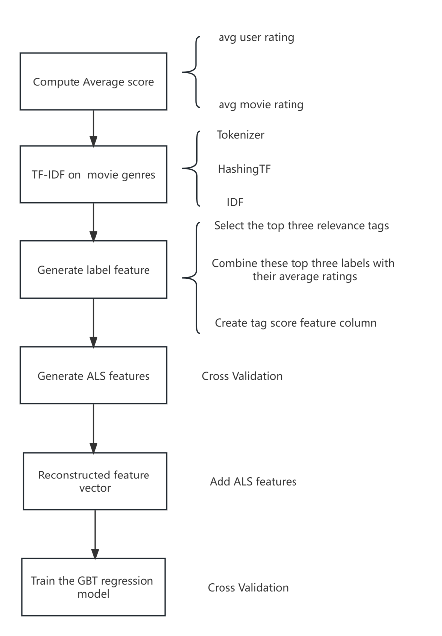

In [3]:
# read data
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)

In [4]:
movies

DataFrame[movieId: int, title: string, genres: string]

In [5]:
from pyspark.sql.functions import explode, split



# Split genres column
split_genres = split(movies['genres'], '\|')

# Convert the split genres into new lines
exploded_genres = movies.withColumn("genre", explode(split_genres))


genre_counts = exploded_genres.groupBy("genre").count()
genre_counts.show()


+------------------+-----+
|             genre|count|
+------------------+-----+
|             Crime| 5319|
|           Romance| 7719|
|          Thriller| 8654|
|         Adventure| 4145|
|             Drama|25606|
|               War| 1874|
|       Documentary| 5605|
|           Fantasy| 2731|
|           Mystery| 2925|
|           Musical| 1054|
|         Animation| 2929|
|         Film-Noir|  353|
|(no genres listed)| 5062|
|              IMAX|  195|
|            Horror| 5989|
|           Western| 1399|
|            Comedy|16870|
|          Children| 2935|
|            Action| 7348|
|            Sci-Fi| 3595|
+------------------+-----+


In [6]:
from pyspark.sql.functions import explode, split, col, lit
from pyspark.sql import functions as F

dummy_genres = exploded_genres.groupBy("movieId").pivot("genre").agg(F.lit(1))

dummy_genres = dummy_genres.na.fill(0)

for genre in dummy_genres.columns[1:]:  
    dummy_genres = dummy_genres.withColumnRenamed(genre, f'{genre}')



### TF-IDF on Movie Types

In [7]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.functions import concat_ws

# Merge genres as a single column
movies_feature = movies.withColumn("all_genres", concat_ws(" ", "genres"))

# Create a Tokenizer to tokenize text
tokenizer = Tokenizer(inputCol="all_genres", outputCol="words")

# Use HashingTF to turn words into feature vectors
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)

# use IDF to adjust the feature vectors
idf = IDF(inputCol="rawFeatures", outputCol="genres_features")

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
pipeline_model = pipeline.fit(movies_feature)
movies_tfidf = pipeline_model.transform(movies_feature)

# Keep only the movieId and features columns
movies_tfidf = movies_tfidf.select("movieId", "genres_features")

# show result
movies_tfidf.show()


+-------+--------------------+
|movieId|     genres_features|
+-------+--------------------+
|      1|(20,[16],[2.82561...|
|      2|(20,[7],[3.451358...|
|      3|(20,[16],[2.82561...|
|      4|(20,[12],[1.65313...|
|      5|(20,[12],[1.65313...|
|      6|(20,[14],[3.84501...|
|      7|(20,[16],[2.82561...|
|      8|(20,[2],[4.066291...|
|      9|(20,[13],[3.24031...|
|     10|(20,[8],[3.847268...|
|     11|(20,[12],[1.65313...|
|     12|(20,[6],[2.606155...|
|     13|(20,[7],[3.451358...|
|     14|(20,[4],[1.667122...|
|     15|(20,[16],[2.82561...|
|     16|(20,[16],[2.82561...|
|     17|(20,[3],[2.012287...|
|     18|(20,[12],[1.65313...|
|     19|(20,[12],[1.65313...|
|     20|(20,[17],[3.57719...|
+-------+--------------------+


### Average Rating Calculation

In [8]:
from pyspark.sql import functions as F
movies_feature = movies.join(movies_tfidf, on="movieId", how="left")

# Calculate the average rating for each movie
movie_avg_ratings = ratings.groupBy("movieId").agg(F.avg("rating").alias("avg_movie_rating"))

# Merge the average rating feature of a movie into the movies_feature DataFrame
movies_feature = movies_feature.join(movie_avg_ratings, on="movieId", how="left")

movies_feature.show()

+-------+--------------------+--------------------+--------------------+------------------+
|movieId|               title|              genres|     genres_features|  avg_movie_rating|
+-------+--------------------+--------------------+--------------------+------------------+
|     12|Dracula: Dead and...|       Comedy|Horror|(20,[6],[2.606155...|2.6245656241646618|
|      1|    Toy Story (1995)|Adventure|Animati...|(20,[16],[2.82561...| 3.893707794587238|
|      3|Grumpier Old Men ...|      Comedy|Romance|(20,[16],[2.82561...| 3.142028126058963|
|      6|         Heat (1995)|Action|Crime|Thri...|(20,[14],[3.84501...| 3.854908898649748|
|     13|        Balto (1995)|Adventure|Animati...|(20,[7],[3.451358...| 3.333527696793003|
|     16|       Casino (1995)|         Crime|Drama|(20,[16],[2.82561...|3.8237068028689416|
|     20|  Money Train (1995)|Action|Comedy|Cri...|(20,[17],[3.57719...|       2.869921875|
|      5|Father of the Bri...|              Comedy|(20,[12],[1.65313...|3.058434

In [9]:
from pyspark.sql import functions as F

# Calculate the average rating for each user
user_avg_ratings = ratings.groupBy("userId").agg(F.avg("rating").alias("avg_rating"))

# The average rating features of users are merged
movies_with_ratings = movies_feature.join(ratings, on="movieId", how="inner")
movies_with_user_avg_ratings = movies_with_ratings.join(user_avg_ratings, on="userId", how="left")

movies_with_user_avg_ratings.show()


+------+-------+--------------------+------+--------------------+-----------------+------+----------+------------------+
|userId|movieId|               title|genres|     genres_features| avg_movie_rating|rating| timestamp|        avg_rating|
+------+-------+--------------------+------+--------------------+-----------------+------+----------+------------------+
|  8249|    148|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   3.0| 835454413|3.1153846153846154|
|  5055|    148|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   3.0| 842463284|3.8815789473684212|
|  3411|    148|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   3.0| 835966104|3.0555555555555554|
|  6491|    148|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   4.0|1500217059| 3.123943661971831|
| 10746|    148|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   3.0| 971898581|3.7024700598802394|
|  7223|    148|Awfully Big Adve

### Tag Relevance Scoring

In [10]:
genome_scores = spark.read.csv("genome-scores.csv", header=True, inferSchema=True)

genome_tags = spark.read.csv("genome-tags.csv", header=True, inferSchema=True)


In [11]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# For each label, find the movie with the highest relevance score
windowSpec = Window.partitionBy("tagId").orderBy(F.desc("relevance"))
top_movie_per_tag = genome_scores.withColumn("rank", row_number().over(windowSpec)) \
                                 .filter(col("rank") == 1) \
                                 .drop("rank")

# Get the average rating of these movies
top_movie_with_ratings = top_movie_per_tag.join(movie_avg_ratings, "movieId")

# The average rating of these movies is used as the tag score
tag_scores = top_movie_with_ratings.select("tagId", "avg_movie_rating")

tag_scores.show()


+-----+------------------+
|tagId|  avg_movie_rating|
+-----+------------------+
|  479|  3.25002094679514|
|   13|2.9753086419753085|
| 1116| 3.553719008264463|
|  195|2.9019607843137254|
|  831|3.9927536231884058|
|  530|3.9927536231884058|
|  186|3.9927536231884058|
|  634| 4.324336165187245|
|  407| 4.324336165187245|
|  345|3.6682604735883424|
| 1051| 4.093231050865188|
|  962| 4.093231050865188|
| 1095| 2.719010989010989|
|  970| 3.349802371541502|
|  969| 3.349802371541502|
| 1061|           2.85625|
| 1034|            2.1875|
|  224|2.6962025316455698|
|  396|3.2010862700517873|
|   90| 4.138093788063338|
+-----+------------------+


In [12]:
# Sort the tags for each movie by relevance
windowSpec = Window.partitionBy("movieId").orderBy(F.desc("relevance"))
tag_relevance_ranked = genome_scores.withColumn("rank", row_number().over(windowSpec))

# The top three labels of relevance scores for each movie are selected
top_tag_relevance_for_movies = tag_relevance_ranked.filter(col("rank") <= 3)

# The tag scores are merged into these top three tags
top_tag_relevance_with_score = top_tag_relevance_for_movies.join(tag_scores, on="tagId")

# relevance * tagScore is calculated for each tag
top_tag_relevance_with_score = top_tag_relevance_with_score.withColumn("relevance_tag_score", col("relevance") * col("avg_movie_rating"))

movie_tag_features = top_tag_relevance_with_score.groupBy("movieId").pivot("rank").agg(F.first("relevance_tag_score"))

movie_tag_features = movie_tag_features.select(col("movieId"),
                                               col("1").alias("tag_relevance_score_1"),
                                               col("2").alias("tag_relevance_score_2"),
                                               col("3").alias("tag_relevance_score_3"))

movie_tag_features.show()

+-------+---------------------+---------------------+---------------------+
|movieId|tag_relevance_score_1|tag_relevance_score_2|tag_relevance_score_3|
+-------+---------------------+---------------------+---------------------+
| 141422|   3.5386157024793388|    3.272461479902558|    3.090652472527473|
|   7993|   3.4007133507853404|           2.53028125|    2.696123595505618|
|    471|   2.6948544303797473|    3.616749599294759|   3.5052805544314043|
|  31367|   2.8932549019607845|       2.528400390625|    3.037497395833333|
| 166558|   3.3581702534493103|    2.756990914597214|    3.065744496855346|
|  41575|   3.6363283582089547|    3.734091473917322|   3.4194311023622044|
| 135867|   3.9917554347826085|    3.975784420289855|    3.972789855072464|
|  26425|    2.740372369908614|    3.448997950819672|   2.4753725490196077|
|   2142|   4.0045065789473675|    2.116978131212724|    3.710266304347826|
|   1829|   3.2823248031496064|   3.0487173660902576|   3.3227023809523812|
|   4900|   

In [13]:

# Merge the movie tag features into the movies_with_user_avg_ratings DataFrame
final_movies_df = movies_with_user_avg_ratings.join(movie_tag_features, on="movieId", how="left")

final_movies_df.show()


+-------+------+--------------------+------+--------------------+-----------------+------+----------+------------------+---------------------+---------------------+---------------------+
|movieId|userId|               title|genres|     genres_features| avg_movie_rating|rating| timestamp|        avg_rating|tag_relevance_score_1|tag_relevance_score_2|tag_relevance_score_3|
+-------+------+--------------------+------+--------------------+-----------------+------+----------+------------------+---------------------+---------------------+---------------------+
|    148|   964|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   1.0| 898995531| 3.707920792079208|    2.712376305970149|   1.6373320895522387|    2.906239376770538|
|    148|  2091|Awfully Big Adven...| Drama|(20,[4],[1.667122...|2.908955223880597|   3.0| 834040799| 3.412280701754386|    2.712376305970149|   1.6373320895522387|    2.906239376770538|
|    148|  2545|Awfully Big Adven...| Drama|(20,[4],[1.667122...|

## Data Integration for Model Training

In [14]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import round


# Select the feature and target columns
feature_columns = final_movies_df.columns
feature_columns.remove("rating")  
feature_columns.remove("title")   
feature_columns.remove("genres")   
feature_columns.remove("timestamp")   
final_movies_df = final_movies_df.na.fill(0)

feature_columns = [col for col in final_movies_df.columns if col not in ["rating", "title", "genres", "timestamp"]]

# Rounds the specified column to four decimal places
for col in feature_columns:
    if col in ['avg_movie_rating', 'avg_rating', 'tag_relevance_score_1', 'tag_relevance_score_2', 'tag_relevance_score_3']:
        final_movies_df = final_movies_df.withColumn(col, round(final_movies_df[col], 4))
# feature_columns.remove("tag_relevance_score_1")   
# feature_columns.remove("tag_relevance_score_2")   
# Creating feature vectors
vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_movies_df = vectorAssembler.transform(final_movies_df.na.fill(0))

# Split the training and test sets
train_df, test_df = final_movies_df.randomSplit([0.7, 0.3], seed=42)



### ALS Feature

In [15]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
full_df = train_df.union(test_df)

# Create ALS model
als = ALS(rank=20, maxIter=15, regParam=0.1, userCol="userId", itemCol="movieId", coldStartStrategy="drop", ratingCol="rating")

# Train ALS model
model = als.fit(train_df)

# Make predictions on the test set
als_predictions = model.transform(full_df)

als_predictions2 = model.transform(test_df)





23/12/09 07:53:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/09 07:53:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [16]:
# evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
# rmse = evaluator.evaluate(als_predictions)
# print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Generate ALS Features

In [17]:
# The ALS prediction result is added as a new feature
als_predictions = als_predictions.withColumnRenamed("prediction", "als_prediction")
feature_columns.append("als_prediction")  

# Remove existing 'features' column (if present)
if 'features' in als_predictions.columns:
    als_predictions = als_predictions.drop('features')
# Recreate the feature vector, containing the ALS prediction
vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
als_predictions = vectorAssembler.transform(als_predictions)
new_train_df, new_test_df = als_predictions.randomSplit([0.7, 0.3], seed=42)




## Model Training and Selection

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    featuresCol="features",
    labelCol="rating",
    maxDepth=6,
    maxBins=40,
    maxIter=20,
    maxMemoryInMB=256,
    cacheNodeIds=False,
    checkpointInterval=10,
    featureSubsetStrategy="all",
    impurity="variance",
    leafCol="",  
    lossType="squared",
    minInfoGain=0.0,
    minInstancesPerNode=1,
    minWeightFractionPerNode=0.0,
    predictionCol="prediction",
    stepSize=0.1,
    subsamplingRate=1.0,
    validationTol=0.01
)
gbt_model = gbt.fit(new_train_df)


new_predictions = gbt_model.transform(new_test_df)
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator

# gbt = GBTRegressor(featuresCol="features", labelCol="rating")

# # Constructing parameter grids
# paramGrid = (ParamGridBuilder()
#              .addGrid(gbt.maxDepth, [4, 5, 6])
#              .addGrid(gbt.maxBins, [32, 40])
#              .addGrid(gbt.maxIter, [10, 20])
#              .addGrid(gbt.stepSize, [0.1, 0.05, 0.01])  
#              .build())


# evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="mse")
# cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# cvModel = cv.fit(als_predictions)

# new_predictions = cvModel.transform(als_predictions)


In [19]:
new_predictions.show()

+-------+------+----------------+--------------------+--------------------+----------------+------+----------+----------+---------------------+---------------------+---------------------+--------------+--------------------+------------------+
|movieId|userId|           title|              genres|     genres_features|avg_movie_rating|rating| timestamp|avg_rating|tag_relevance_score_1|tag_relevance_score_2|tag_relevance_score_3|als_prediction|            features|        prediction|
+-------+------+----------------+--------------------+--------------------+----------------+------+----------+----------+---------------------+---------------------+---------------------+--------------+--------------------+------------------+
|      1|   516|Toy Story (1995)|Adventure|Animati...|(20,[16],[2.82561...|          3.8937|   3.0| 849435984|    3.5909|               3.8908|               3.8888|                3.928|      3.768131|(28,[0,1,18,22,23...|3.9087276521670633|
|      1|   858|Toy Story (1

In [21]:

# RMSE
evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(new_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# MSE
evaluator.setMetricName("mse")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)

# MAE
evaluator.setMetricName("mae")
mae = evaluator.evaluate(new_predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

# R2
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(new_predictions)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 0.747656


Mean Squared Error (MSE) on test data = 0.55899


Mean Absolute Error (MAE) on test data = 0.567814


R2 on test data = 0.503459


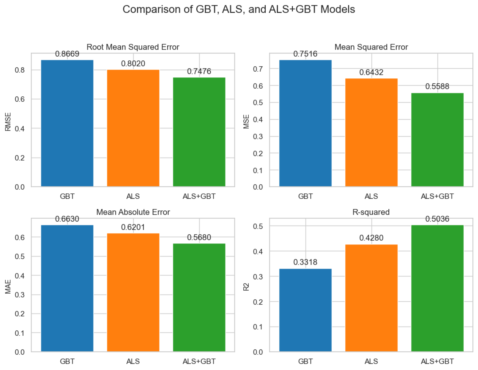

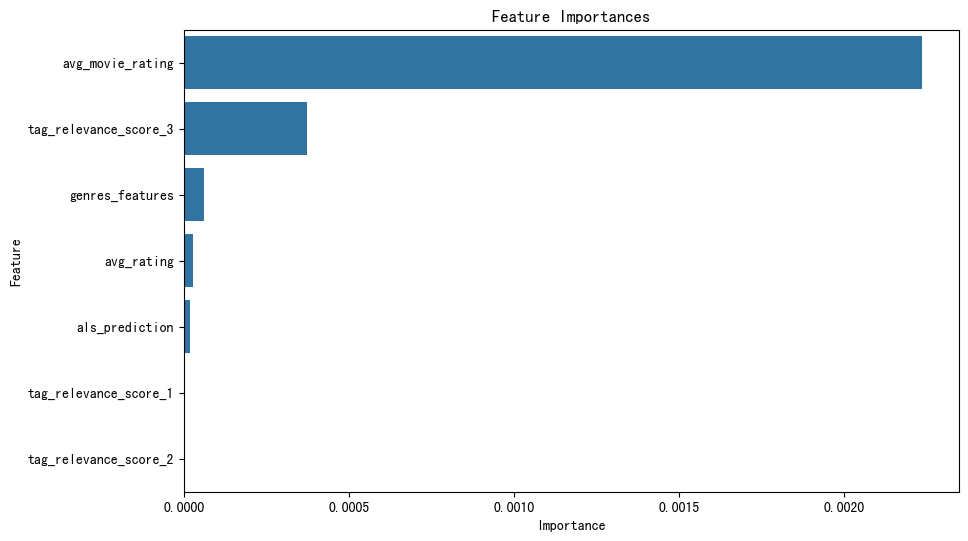

In [22]:
feature_importances =gbt_model.featureImportances
import pandas as pd


feature_columns = ['avg_movie_rating', 'avg_rating', 'tag_relevance_score_1', 'tag_relevance_score_2', 'tag_relevance_score_3', 'als_prediction','genres_features']


importances_pd = pd.DataFrame(list(zip(feature_columns, feature_importances.toArray())),
                              columns=["Feature", "Importance"]).sort_values("Importance", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importances_pd)
plt.title('Feature Importances')
plt.show()



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


als_predictions_pd = als_predictions2.select("rating", "prediction").toPandas()
gbt_predictions_pd = new_predictions.select("rating", "prediction").toPandas()




/usr/local/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/usr/local/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


/tmp/ipykernel_5323/2136785722.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(als_predictions_pd["prediction"], label="ALS", shade=True)
/tmp/ipykernel_5323/2136785722.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gbt_predictions_pd["prediction"], label="ALS + GBT", shade=True, color="orange")


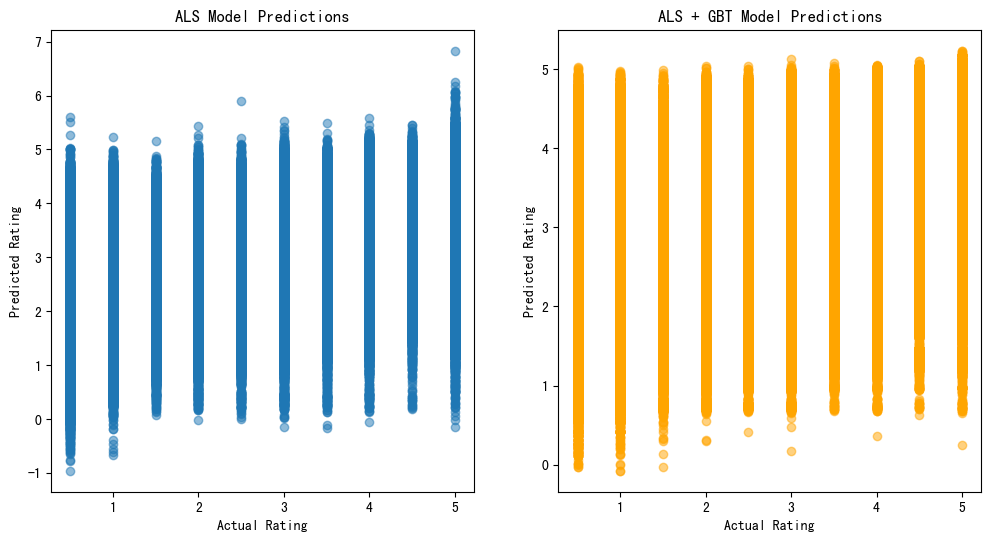

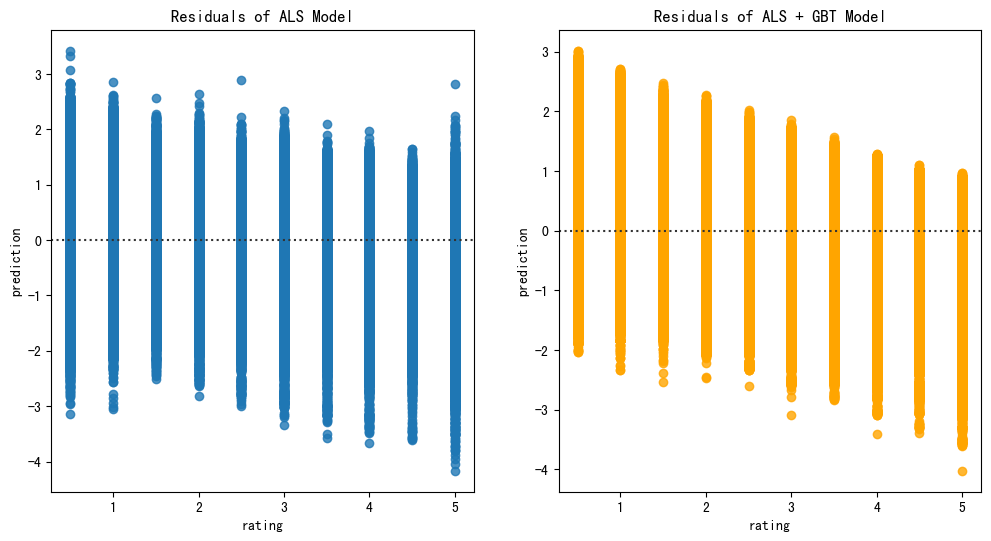

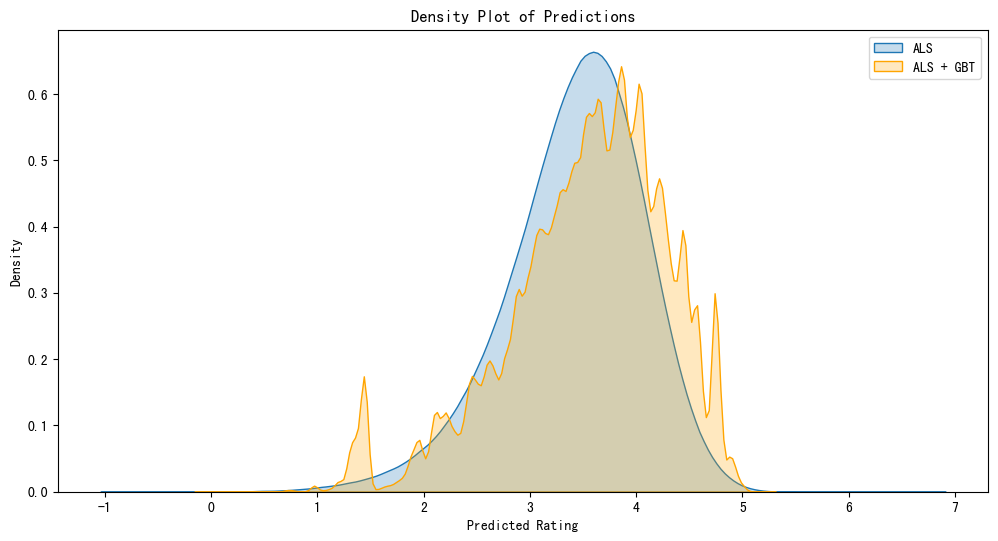

In [26]:
# Scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(als_predictions_pd["rating"], als_predictions_pd["prediction"], alpha=0.5)
plt.title("ALS Model Predictions")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

plt.subplot(1, 2, 2)
plt.scatter(gbt_predictions_pd["rating"], gbt_predictions_pd["prediction"], alpha=0.5, color="orange")
plt.title("ALS + GBT Model Predictions")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

# Residual plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.residplot(x="rating", y="prediction", data=als_predictions_pd)
plt.title("Residuals of ALS Model")

plt.subplot(1, 2, 2)
sns.residplot(x="rating", y="prediction", data=gbt_predictions_pd, color="orange")
plt.title("Residuals of ALS + GBT Model")

# Density map
plt.figure(figsize=(12, 6))
sns.kdeplot(als_predictions_pd["prediction"], label="ALS", shade=True)
sns.kdeplot(gbt_predictions_pd["prediction"], label="ALS + GBT", shade=True, color="orange")
plt.title("Density Plot of Predictions")
plt.xlabel("Predicted Rating")
plt.legend()

plt.show()

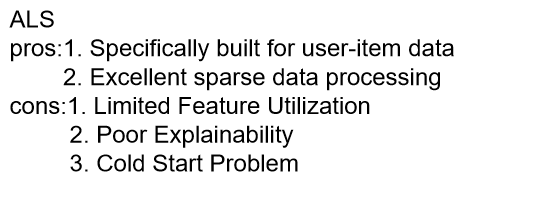

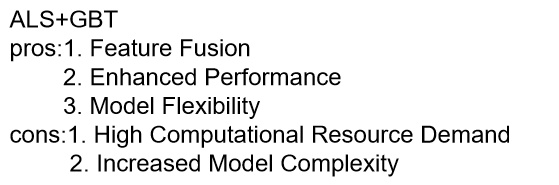

Try to convert a regression problem into a classification problem

In [27]:
from pyspark.sql.functions import col, when, round as round_col

# Round the predicted value
predictions_cl_rounded = new_predictions.withColumn(
    "prediction_rounded",
    when(
        col("prediction") - round_col(col("prediction")) < 0.25, 
        round_col(col("prediction"))
    ).otherwise(
        round_col(col("prediction")) + 0.5
    )
)

# compute accuracy
correct_predictions = predictions_cl_rounded.filter(col("prediction_rounded") == col("rating")).count()
total_predictions = predictions_cl_rounded.count()
accuracy = correct_predictions / total_predictions

print(f"accuracy = {accuracy * 100}%")



accuracy = 34.65172166267628%
